##### Last edited by Claire Valva on August 1, 2018

## Mean Z histograms and departure from climatological means

##### to do:

1. figure out why I can't access time as a variable when uploading netcdf file

2. The revised analysis looks good.  A minor point: in the spaghetti diagrams I noticed that some curves have kinks.  Again most likely this is due to a slight glitch in indexing — can you fix that?

Then, to clean up the results so far, let's do the following:

(1) Superpose the histograms of total geopotential and those of geoptential using climatological-mean monthly means (no interannual variabilities in the monthly mean) - mean over month and lon, on the same axes with different colors
(2) Superpose the histograms of daily geopotential anomalies and those of 4-day average anomalies on the same axes with different colors?

Also if you can, can you indicate the average values [two distinct values for (1) and 0 for (2)] with solid vertical lines in each diagram, so that you can visually tell whether the peak is shifted to the right or to the left.

(3) Repeat (1)(2) using the log scale in the abscissa so that we can see the tail ends of the distribution more clearly.

Once we are done this far, we’ll write up a short summary and then focus on the spectral analysis.

#### file details: 
will be using file: 1979-2016-300hPa-40.5N-z.nc which is currently located in ~/uncategorized data

This file contains a single 2D array called “z”, whose dimension is (240, 55520). The first dimension is longitude, 1.5 degree interval from 0 to 358.5 (0 is Greenwich Mean). The second dimension is time, 6 hours apart, from 00 UTC January 1, 1979 to 18 UTC December 31, 2016. The unit is meters^2/sec^2. Divide by g = 9.81 m/s^2 to obtain geopotential height, the altitude at which you find 300 hPa.

In [12]:
#import packages
import numpy as np
from netCDF4 import Dataset, num2date # This is to read .nc files and time array
from scipy.signal import get_window, csd
from scipy.fftpack import fft, ifft, fftshift, fftfreq
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import pandas as pd
import datetime
from math import pi
import csv
from IPython.display import display, Markdown, Latex
import seaborn as sns

In [13]:
#import file
filepath = '/home/clairev/uncategorized-data/1979-2016-300hPa-40.5N-z.nc' # Location of the file
fileobj = Dataset(filepath, mode='r')

# Check what's in there
fileobj

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): longitude(240), time(55520)
    variables(dimensions): float32 z(time,longitude)
    groups: 

In [28]:
#set indicies/number of things
number_entries = int(fileobj.dimensions['time'].size)
number_days = int(number_entries / 4)
number_lon = fileobj.dimensions['longitude'].size
year_number = 2016 - 1979

In [17]:
#load coordinates
#so height[i] is the geopotential height at a given time
height = fileobj.variables['z'][:]
g = 1/9.81
height = height*g

#create time array
time_list = []
for i in range(0,55520):
    time_list.append(i*6)
tunit = "hours since 1979-01-01T00:00:00Z"
tarray = num2date(time_list,units = tunit,calendar = 'gregorian')

#create longitude array
lon_increment = 1.5 # The increment of each longitude grid is 1.5
lon_list = [i * lon_increment for i in range(240)]

# Find mean geopotential heights and differences

##### to do: fix lower cell for efficiency

In [88]:
#first get the average of each individual day
days = []
for i in range(number_entries):
    for k in range(number_lon):
        
        #get the longitdue
        lon = lon_list[k]
        
        #get the geopotential heights for the day
        z_temp = height[i][k]
        
        #group them together 
        toappend = {'datetime' : tarray[i], 'lon': lon,
                    'z' : z_temp}
        
        days.append(toappend)

In [89]:
#make this a dataframe
geopot_df = pd.DataFrame(days)

In [90]:
#get day/month/year separately for groupby
geopot_df['month'] = geopot_df['datetime'].apply(lambda x: x.month)
geopot_df['day'] = geopot_df['datetime'].apply(lambda x: x.day)
geopot_df['year'] = geopot_df['datetime'].apply(lambda x: x.year)

In [91]:
#append season to each row
def season_sort(x):
    if x < 3:
        return("winter")
    elif x >= 12:
        return("winter")
    elif x >= 3 and x < 6:
        return("spring")
    elif x >= 6 and x < 9:
        return("summer")
    elif x >= 9 and x < 12:
        return("fall")
    else:
        return("error?")
    
geopot_df["season"] = geopot_df["month"].apply(lambda x: season_sort(x))

In [92]:
#find mean over several vars
geopot_df["dayavg"] = geopot_df.groupby(by=['month', 'year','lon', 'day'])['z'].transform('mean')
geopot_df["monthmean"] = geopot_df.groupby(by=['month', 'year','lon'])['z'].transform('mean')
geopot_df["clim_monthmean"] = geopot_df.groupby(by=['month','lon'])['z'].transform('mean')
geopot_df["seasonmean"] = geopot_df.groupby(by=['year','lon','season'])['z'].transform('mean')

In [93]:
#find the difference between monthmeans and climmonth means
geopot_df["difference_month"] = geopot_df['z'] - geopot_df["monthmean"]
geopot_df["difference_climmonth"] = geopot_df['z'] - geopot_df["clim_monthmean"]

In [94]:
#to compare - get the average of four day sections
avg4_df = geopot_df.drop_duplicates(subset=['dayavg'], keep='first', inplace=False)
avg4_df = avg4_df.sort_values(by = ['lon','datetime'])
avg4_df = avg4_df.groupby(np.arange(len(avg4_df))//4).mean()
avg4_df["season"] = avg4_df["month"].apply(lambda x: season_sort(x))

#### set parameters / lon sections for plotting

#set lists of seasons
winter_str = 'month < 3 | month == 12'
spring_str = 'month >= 3 & month <= 5'
summer_str = 'month >= 6 & month <= 8'
fall_str = 'month >= 9 & month <= 11'

season_list = [winter_str, spring_str, summer_str, fall_str]

In [95]:
#set lists of longitude sections
lon_1 = 'lon >= 50 & lon <= 140'
lon_2 = 'lon <= 50 | lon >= 320'
lon_3 = 'lon >= 230 & lon <= 320'
lon_4 = 'lon >= 140 & lon <= 230'

lon_sections = [lon_1, lon_2, lon_3, lon_4]

season_label = ["winter","spring","summer","fall"]

## seasonal means as a function of year and longitude

Analysis so far shows that in the instances where the total distribution (monthly mean + departure) is modal, the peak is clearly shifted to the right, which indicates that anomalies are more commonly observed to be ridges, despite that ridges and troughs occur equally likely on the 1-4 day timescale.  Therefore, a constructive interference between the seasonal mean (stationary wave) and high frequency transients is the likely explanation for the predominance of ridges.  If confirmed, that would be a good result.   


In [96]:
#create a list of years and a gradient color pallete
# so there is at least some sense of what year each line is?
year_list = [1979 + i for i in range(year_number)]

colormap = plt.cm.gist_ncar
colors = [colormap(i) for i in np.linspace(0, 0.9, year_number)]

In [99]:
#drop the duplicates so am only pltting one point in each place
season_df = geopot_df.drop_duplicates(subset=['seasonmean'], keep='first', inplace=False)

/home/clairev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  


<Figure size 432x288 with 0 Axes>

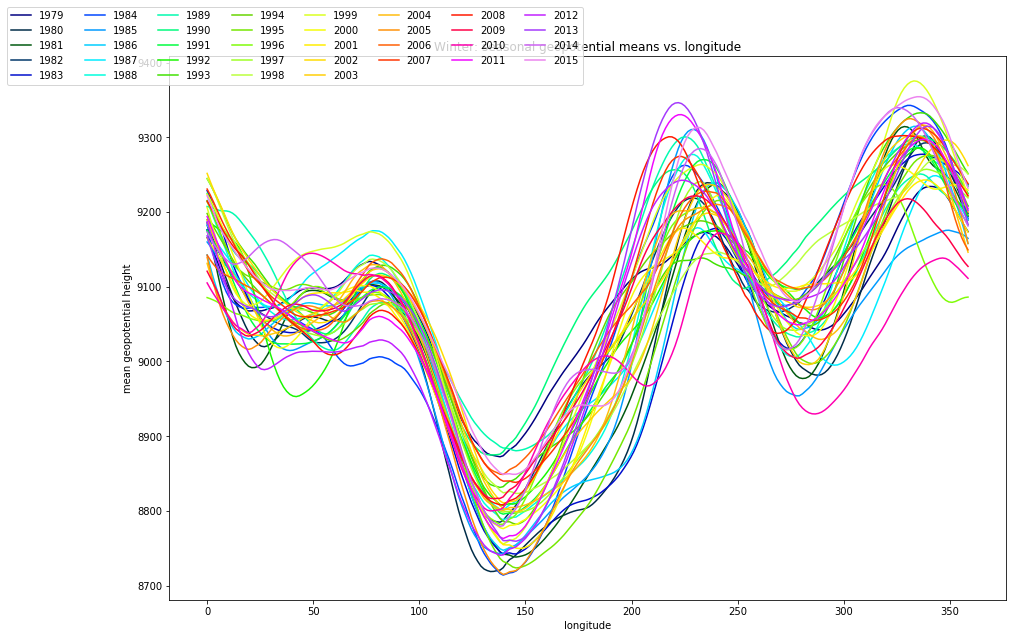

In [100]:
winter_df = season_df[season_df['season'] == "winter"]


plt.clf();
plt.figure(figsize=(15,10))
plt.gca().set_color_cycle(colors)
for year_chk in year_list:
    frame = winter_df[winter_df['year'] == year_chk]
    plt.plot(frame["lon"], frame["seasonmean"])
#plt.legend(bbox_to_anchor=(1.05,0.5))
plt.legend(year_list, bbox_to_anchor=[0.5, 1.1],
          ncol=8)
plt.title("Winter: seasonal geopotential means vs. longitude")
plt.xlabel("longitude")
#plt.xlim((0, 350)) 
plt.ylabel("mean geopotential height")
plt.show()

/home/clairev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  """


<Figure size 432x288 with 0 Axes>

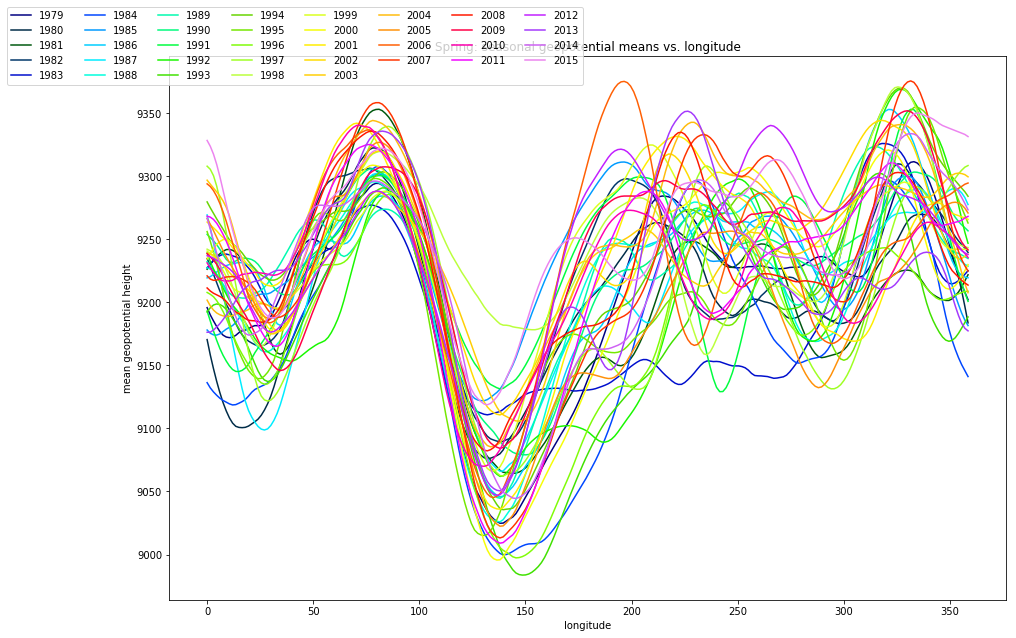

In [101]:
spring_df = season_df[season_df['season'] == "spring"]

plt.clf();
plt.figure(figsize=(15,10))
plt.gca().set_color_cycle(colors)
for year_chk in year_list:
    frame = spring_df[spring_df['year'] == year_chk]
    plt.plot(frame["lon"], frame["seasonmean"])
plt.legend(year_list, bbox_to_anchor=[0.5, 1.1],
          ncol=8)
plt.title("Spring: seasonal geopotential means vs. longitude")
plt.xlabel("longitude")
plt.ylabel("mean geopotential height")
plt.show()

/home/clairev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  """


<Figure size 432x288 with 0 Axes>

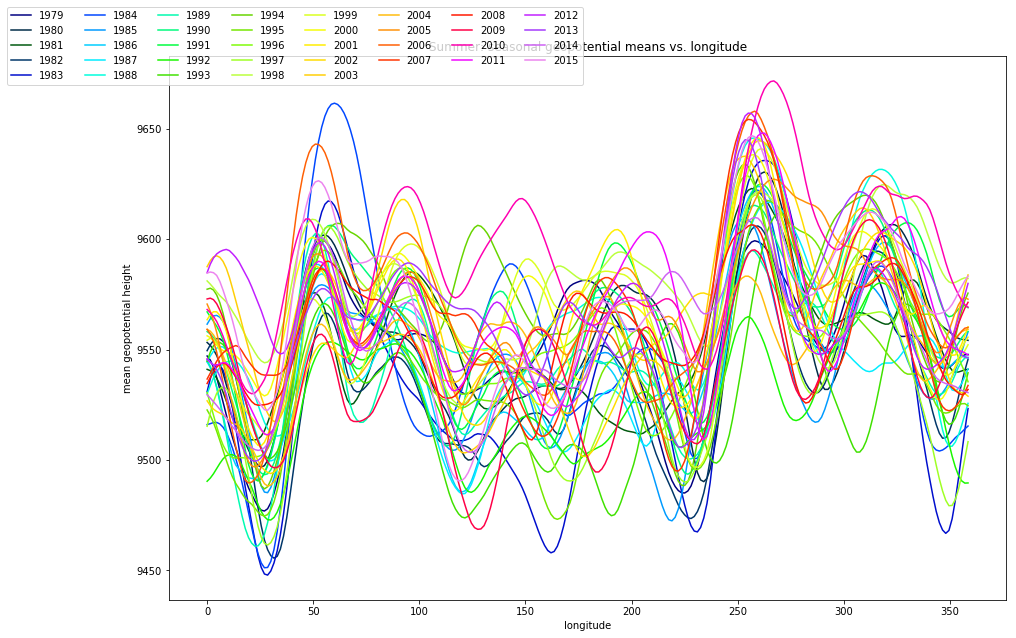

In [102]:
summer_df = season_df[season_df['season'] == "summer"]

plt.clf();
plt.figure(figsize=(15,10))
plt.gca().set_color_cycle(colors)
for year_chk in year_list:
    frame = summer_df[summer_df['year'] == year_chk]
    plt.plot(frame["lon"], frame["seasonmean"])
#plt.legend(bbox_to_anchor=(1.05,0.5))
plt.legend(year_list, bbox_to_anchor=[0.5, 1.1],
          ncol=8)
plt.title("Summer: seasonal geopotential means vs. longitude")
plt.xlabel("longitude")
plt.ylabel("mean geopotential height")
plt.show()

/home/clairev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  """


<Figure size 432x288 with 0 Axes>

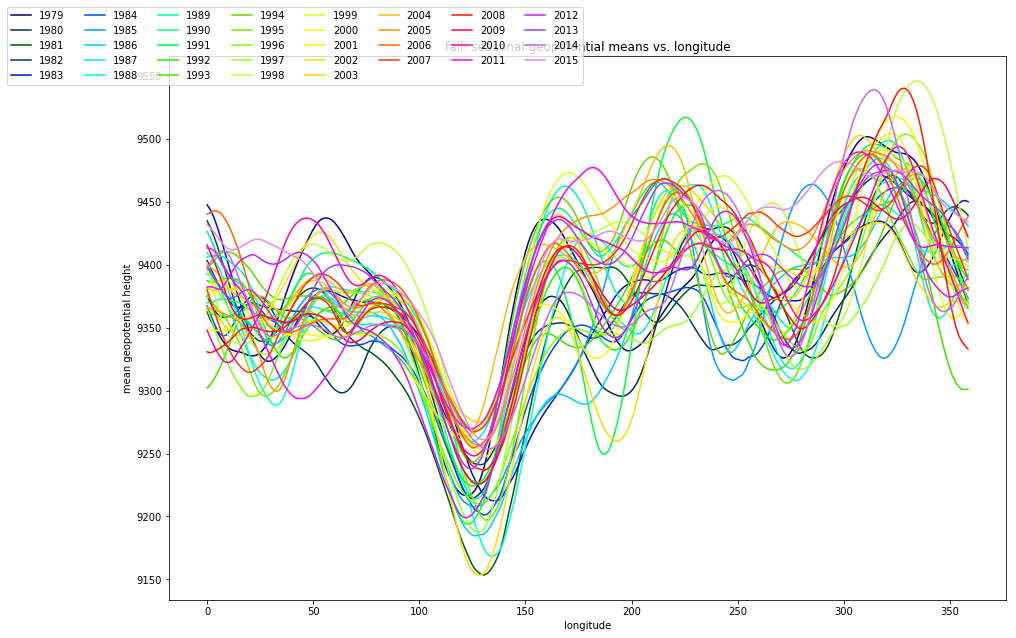

In [103]:
fall_df = season_df[season_df['season'] == "fall"]

plt.clf();
plt.figure(figsize=(15,10))
plt.gca().set_color_cycle(colors)
for year_chk in year_list:
    frame = fall_df[fall_df['year'] == year_chk]
    plt.plot(frame["lon"], frame["seasonmean"])
plt.legend(year_list, bbox_to_anchor=[0.5, 1.1],
          ncol=8)
plt.title("fall: seasonal geopotential means vs. longitude")
plt.xlabel("longitude")
plt.ylabel("mean geopotential height")
plt.show()

## Departure from the mean of geopotential height as a function of month (over all years)
(1) For each year at each grid point, compute monthly mean value.

(2) At each grid point average the monthly mean values over 38 years to compute climatological mean, monthly-mean value (thereby we remove the interannual variability).

(3) Reconstruct the total distribution by adding back the daily anomalies, but using the monthly mean values computed in (2) for all years, rather than the monthly mean values for individual years.

#### histograms here:

In [110]:
day_df

,datetime,lon,z,month,day,year,season,dayavg,monthmean,clim_monthmean,seasonmean,difference_month,difference_climmonth
0,1979-01-01,0.0,9280.047852,1,1,1979,winter,9238.243164,9144.247362,9182.794797,9165.978602,135.800490,97.253054
1,1979-01-01,1.5,9263.715820,1,1,1979,winter,9221.132812,9139.568288,9173.594076,9156.305756,124.147532,90.121744
2,1979-01-01,3.0,9248.937500,1,1,1979,winter,9199.549561,9133.019996,9164.493936,9146.386955,115.917504,84.443564
3,1979-01-01,4.5,9231.049805,1,1,1979,winter,9172.134277,9123.730705,9155.383208,9136.155279,107.319100,75.666596
4,1979-01-01,6.0,9203.050781,1,1,1979,winter,9140.635010,9111.587607,9146.340337,9125.200206,91.463174,56.710444
5,1979-01-01,7.5,9181.272461,1,1,1979,winter,9117.690674,9097.945446,9137.788306,9114.534402,83.327015,43.484154
6,1979-01-01,9.0,9170.384766,1,1,1979,winter,9104.663330,9083.117920,9129.632196,9104.477555,87.266846,40.752570
7,1979-01-01,10.5,9155.606445,1,1,1979,winter,9090.274414,9067.456102,9121.564133,9094.619366,88.150343,34.042313
8,1979-01-01,12.0,9136.162109,1,1,1979,winter,9071.024658,9052.873071,9113.794582,9085.860623,83.289039,22.367528
9,1979-01-01,13.5,9123.717773,1,1,1979,winter,9054.886230,9041.225436,9106.787546,9079.423812,82.492337,16.930227


In [108]:
#create a list of seasons to cycle through
season_list = ["winter", "spring", "summer", "fall"]

## season: winter

<Figure size 432x288 with 0 Axes>

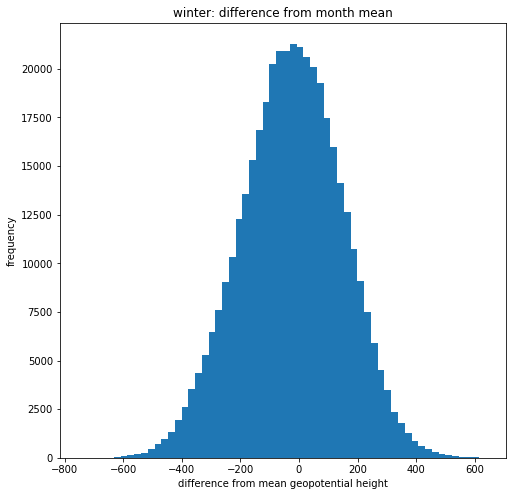

<Figure size 432x288 with 0 Axes>

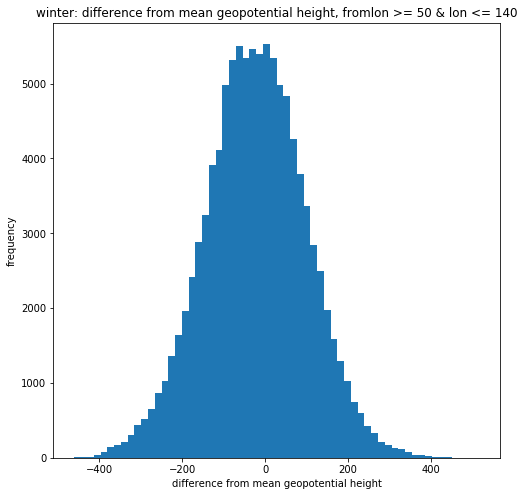

<Figure size 432x288 with 0 Axes>

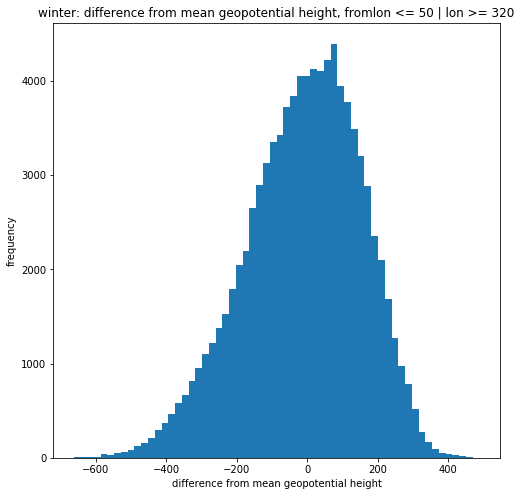

<Figure size 432x288 with 0 Axes>

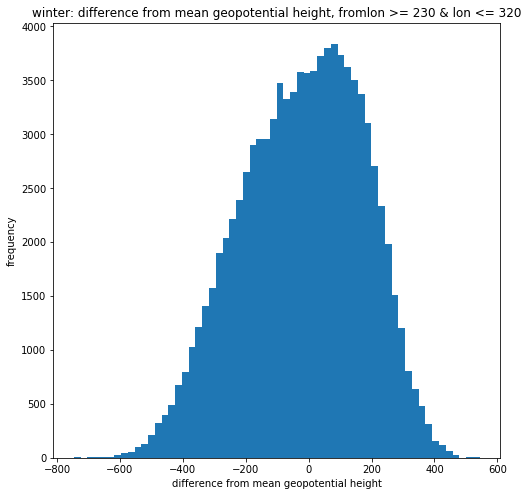

<Figure size 432x288 with 0 Axes>

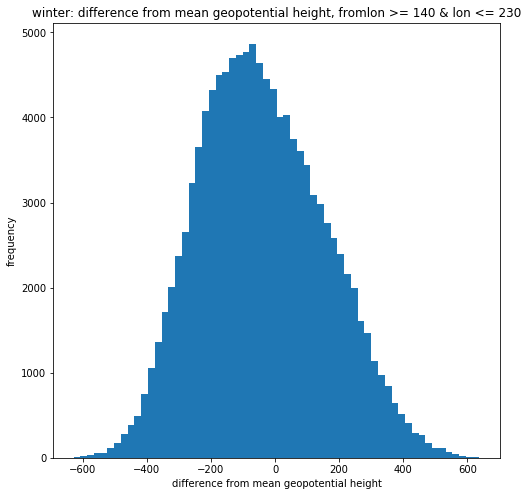

## season: spring

<Figure size 432x288 with 0 Axes>

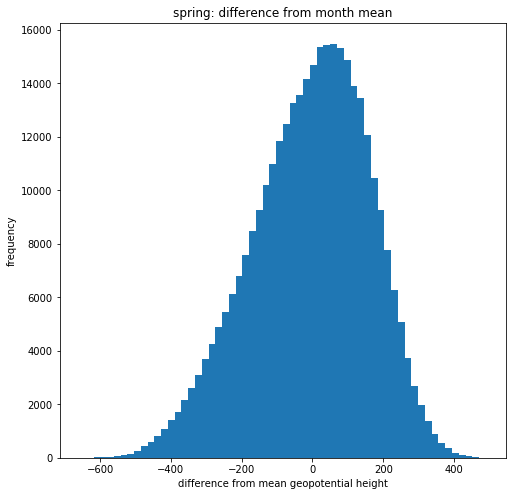

<Figure size 432x288 with 0 Axes>

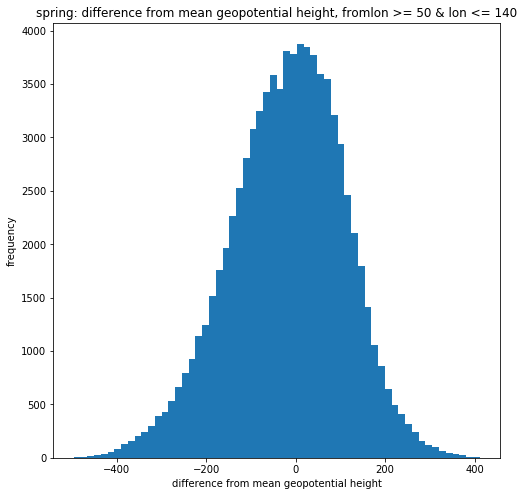

<Figure size 432x288 with 0 Axes>

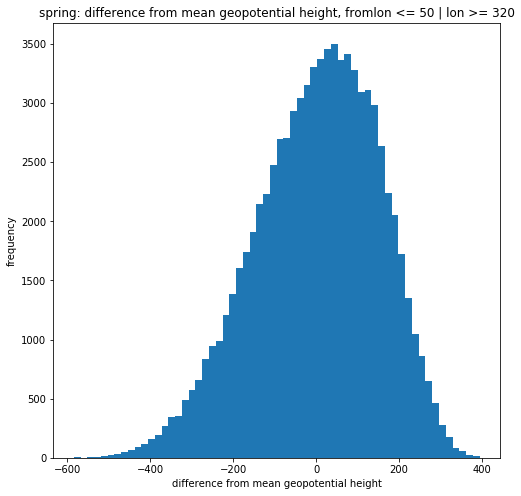

<Figure size 432x288 with 0 Axes>

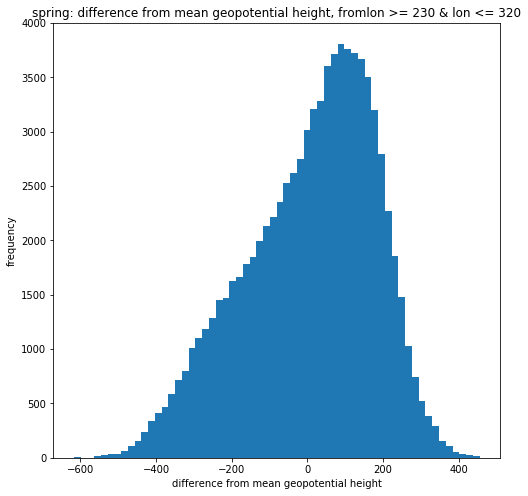

<Figure size 432x288 with 0 Axes>

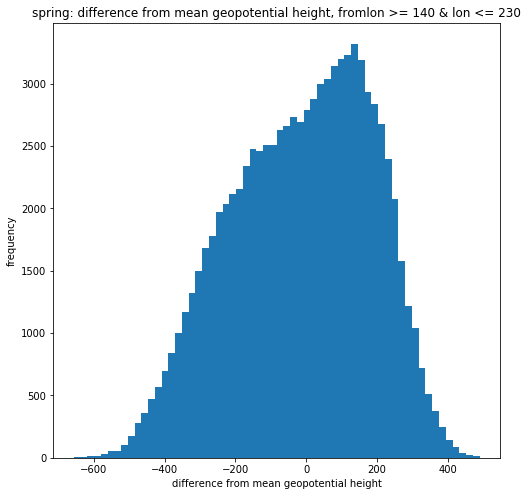

## season: summer

<Figure size 432x288 with 0 Axes>

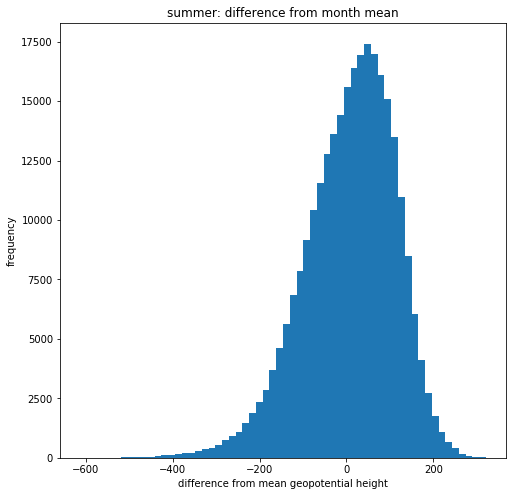

<Figure size 432x288 with 0 Axes>

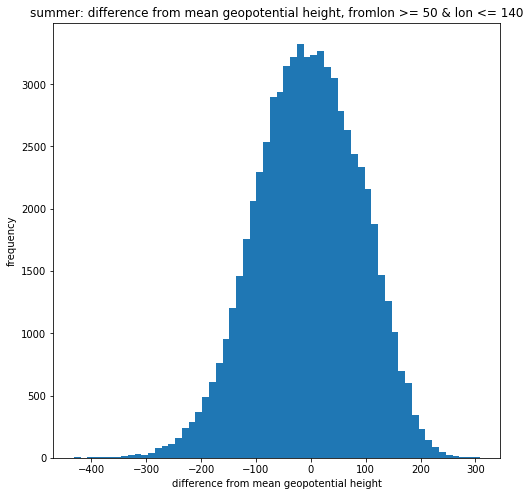

<Figure size 432x288 with 0 Axes>

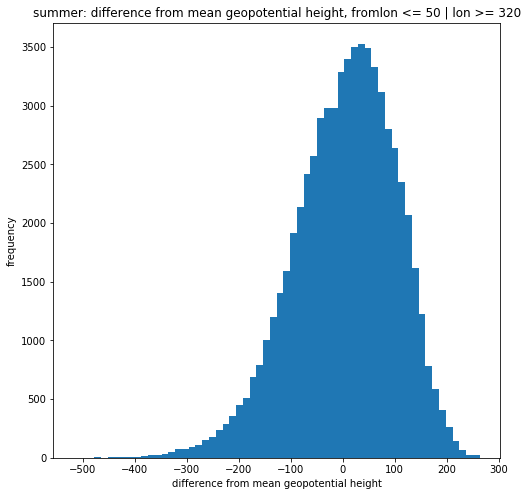

<Figure size 432x288 with 0 Axes>

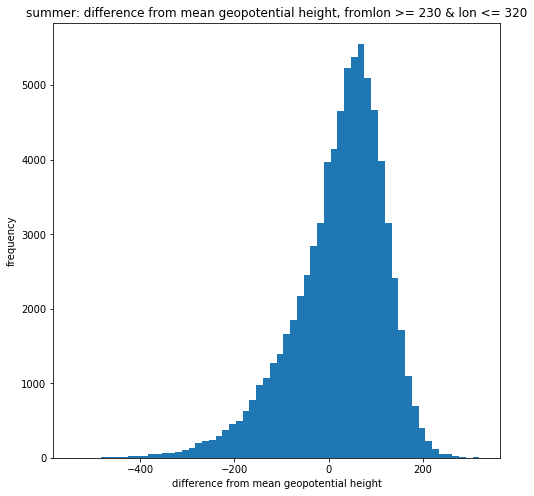

<Figure size 432x288 with 0 Axes>

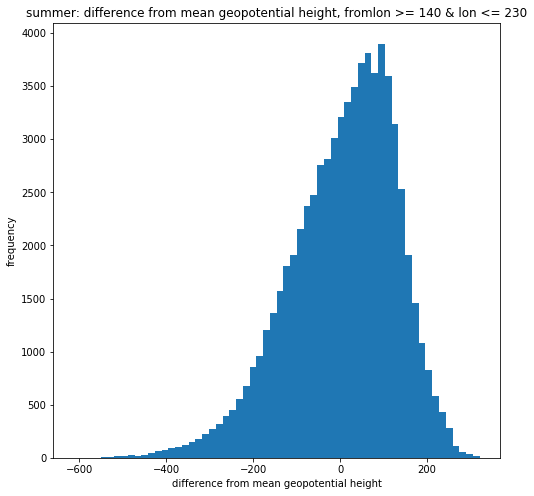

## season: fall

<Figure size 432x288 with 0 Axes>

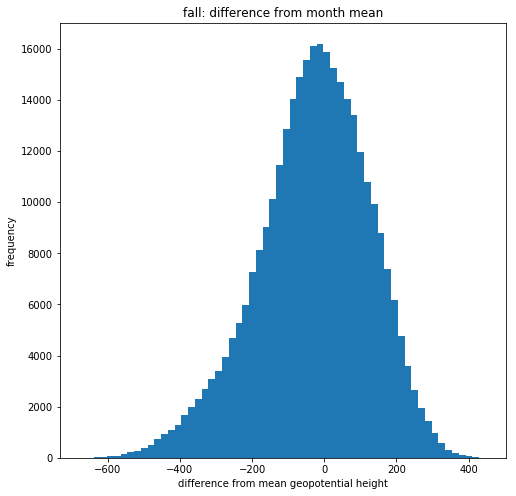

<Figure size 432x288 with 0 Axes>

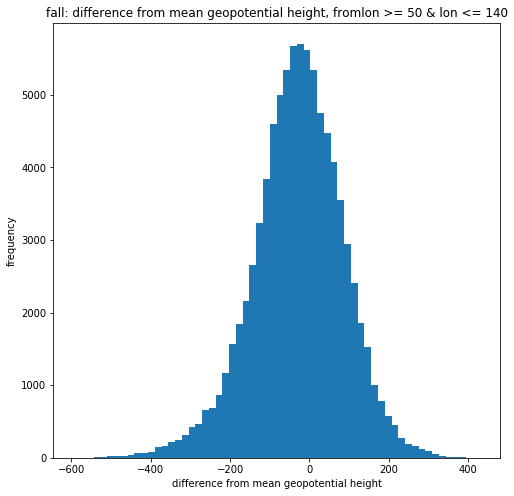

<Figure size 432x288 with 0 Axes>

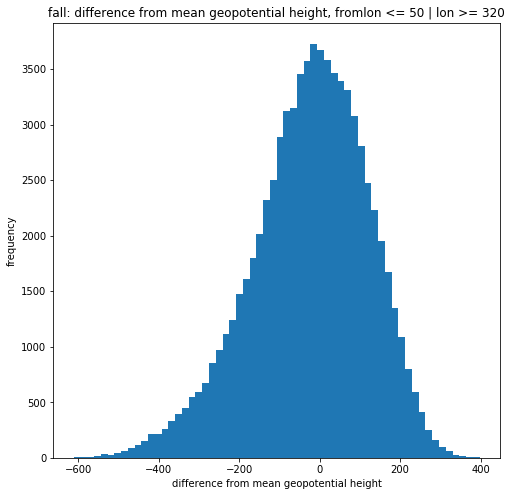

<Figure size 432x288 with 0 Axes>

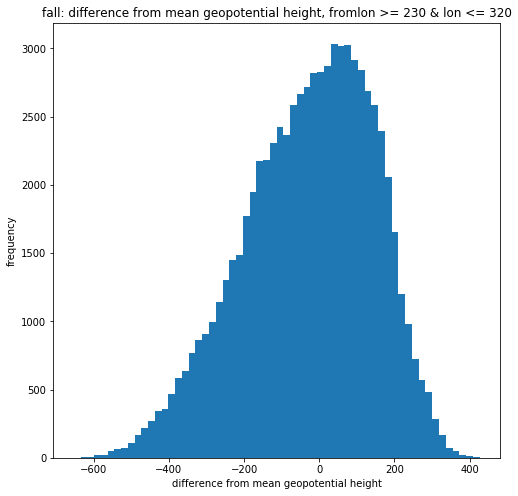

<Figure size 432x288 with 0 Axes>

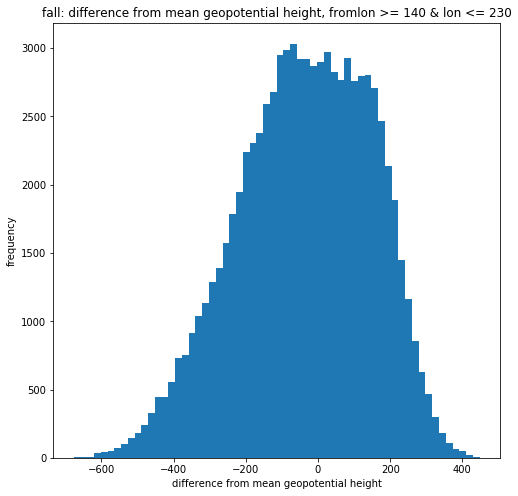

In [113]:
#drop the duplicates so am only pltting one point in each place
day_df = geopot_df.drop_duplicates(subset=['dayavg'], keep='first', inplace=False)

for season in season_list:
    
    #display season
    display(Markdown('## season: ' + season))
    
    #get the correct dataframe
    plot_df = day_df[day_df["season"] == season]
    
    #plot the histogram for the entire season
    plt.clf();
    plt.figure(figsize=(8,8))
    plt.hist(plot_df['difference_climmonth'], bins = 60)
    #plt.xlim(xmin,xmax)
    plt.ylabel('frequency')
    plt.xlabel('difference from mean geopotential height')
    plt.title(season + ': difference from month mean');
    plt.show()
    
    
    
    for section in lon_sections:
        
        #get the correct dataframe
        section_df = plot_df.query(section)
        
        #plot the figure
        plt.clf();
        plt.figure(figsize=(8,8))
        plt.hist(section_df['difference_climmonth'], bins = 60)
        plt.ylabel('frequency')
        plt.xlabel('difference from mean geopotential height')
        plt.title(season + ': difference from mean geopotential height, from' + section);
        plt.show()
        
    i = i + 1

## Departure of Geopotential Mean (Four day average)
These histograms are the departure of the geopotential mean for a four day average, in order to compare with previous histograms (1 day average). For the 1 day average, the distributions are roughly symmetric, do the four-day average values show a longer tail in ridges/positive?

In [115]:
avg4_df.columns

#drop the duplicates (again)
plot_df 

Index(['lon', 'z', 'month', 'day', 'year', 'dayavg', 'monthmean',
       'clim_monthmean', 'seasonmean', 'difference_month',
       'difference_climmonth', 'season'],
      dtype='object')

## season: winter

<Figure size 432x288 with 0 Axes>

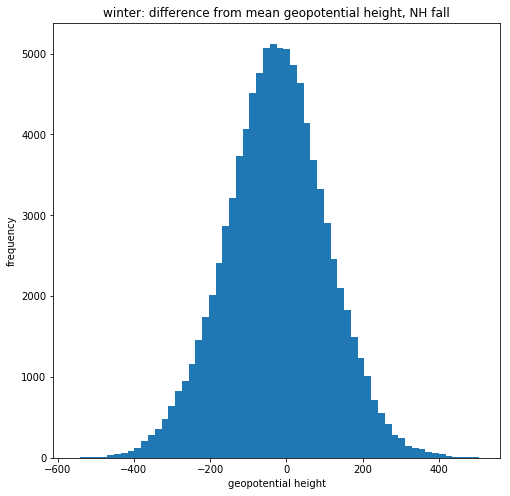

<Figure size 432x288 with 0 Axes>

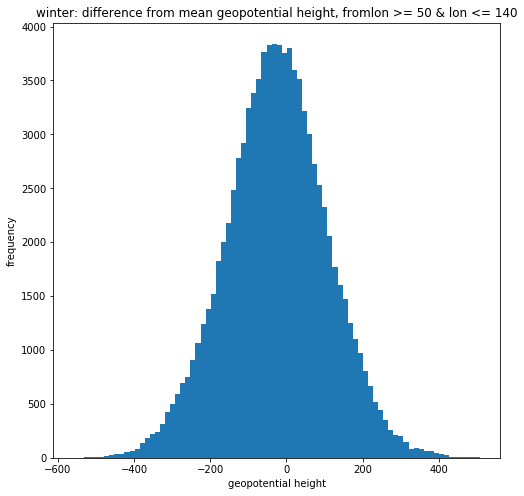

<Figure size 432x288 with 0 Axes>

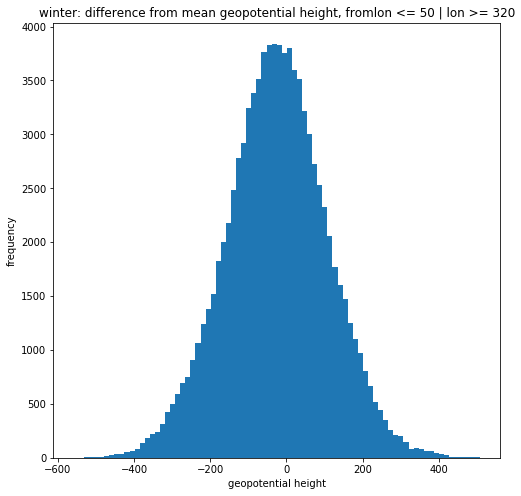

<Figure size 432x288 with 0 Axes>

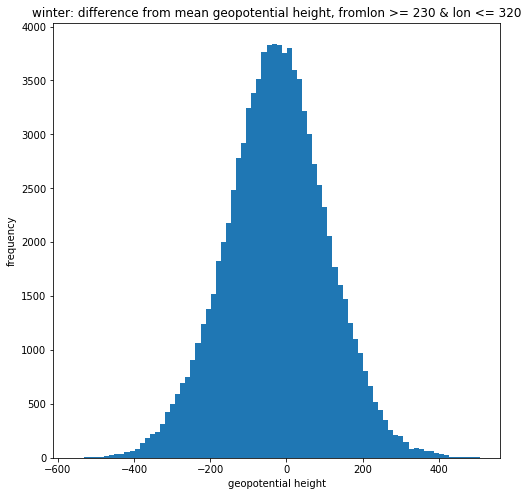

<Figure size 432x288 with 0 Axes>

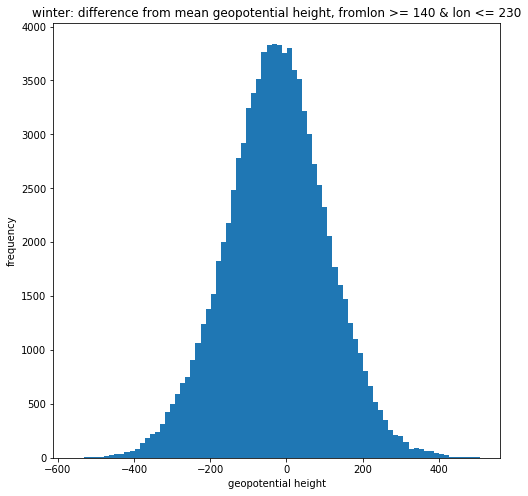

## season: spring

<Figure size 432x288 with 0 Axes>

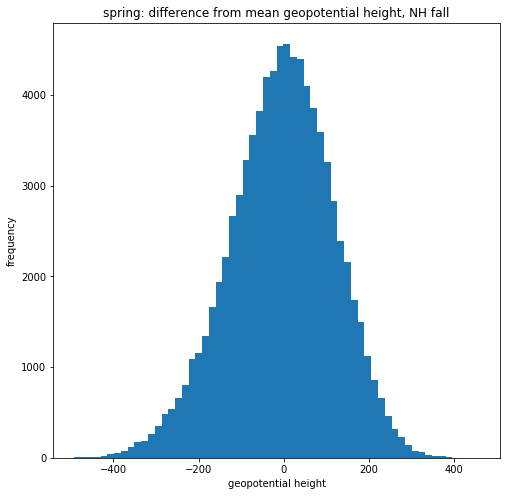

<Figure size 432x288 with 0 Axes>

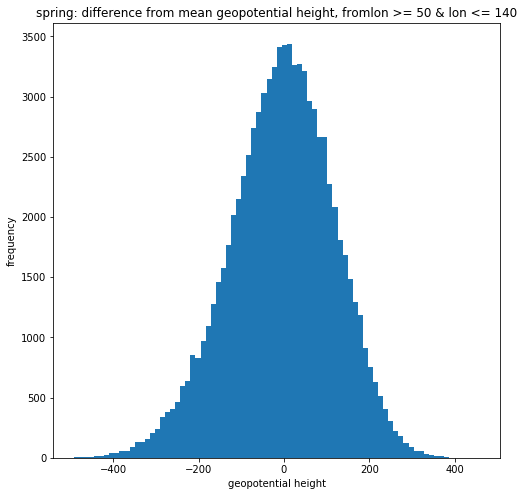

<Figure size 432x288 with 0 Axes>

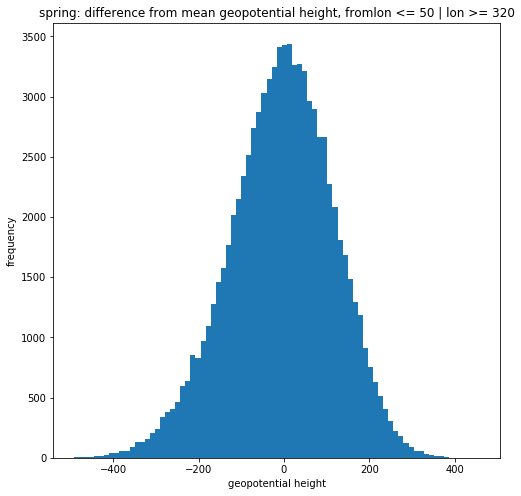

<Figure size 432x288 with 0 Axes>

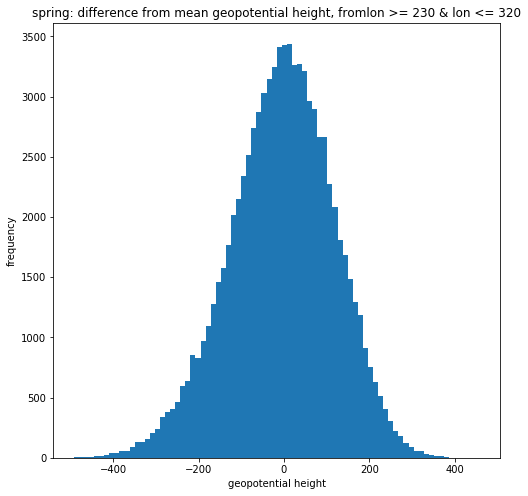

<Figure size 432x288 with 0 Axes>

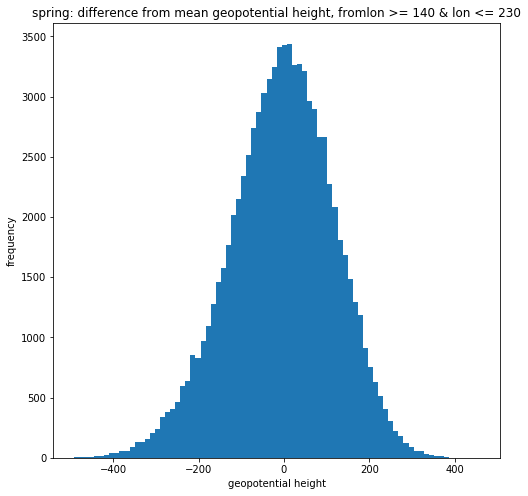

## season: summer

<Figure size 432x288 with 0 Axes>

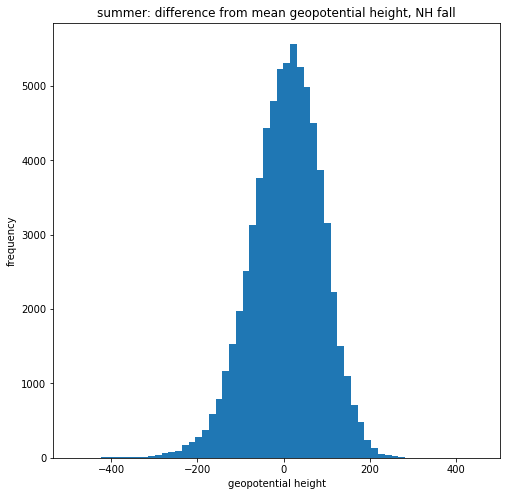

<Figure size 432x288 with 0 Axes>

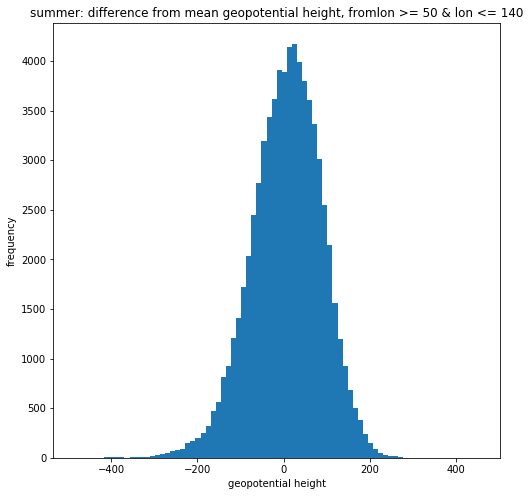

<Figure size 432x288 with 0 Axes>

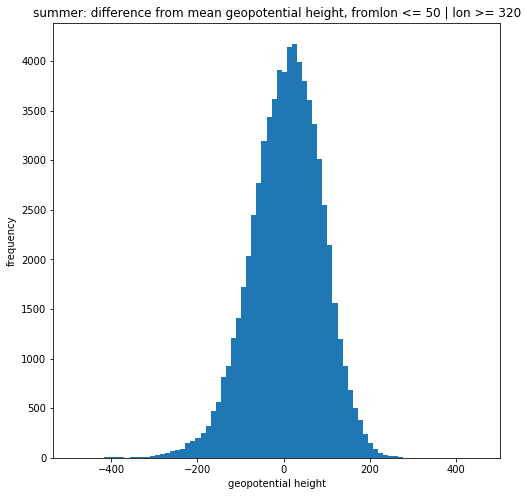

<Figure size 432x288 with 0 Axes>

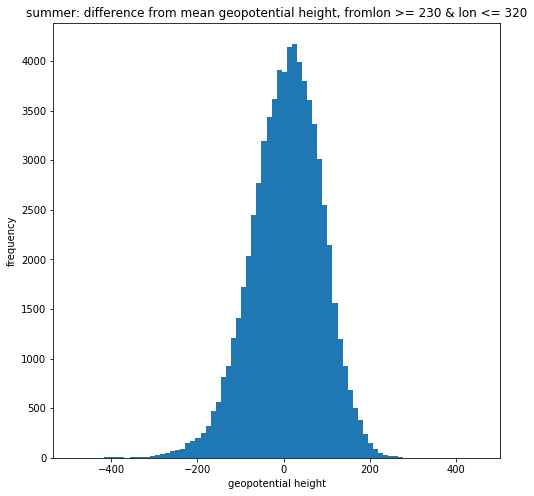

<Figure size 432x288 with 0 Axes>

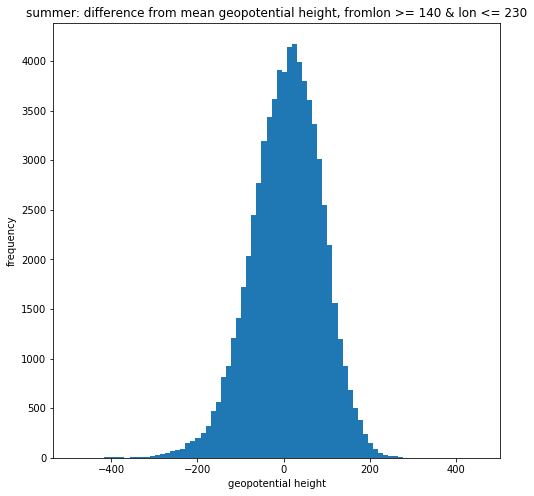

## season: fall

<Figure size 432x288 with 0 Axes>

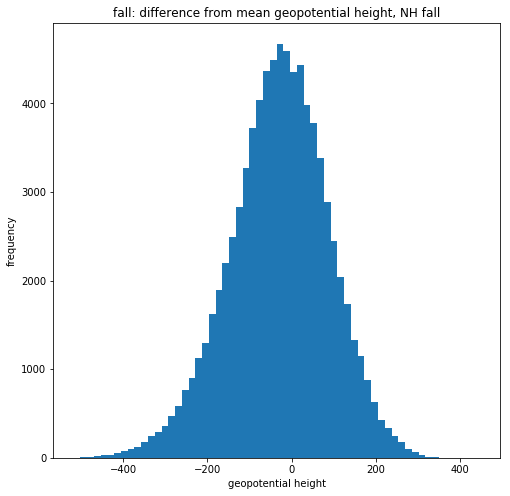

<Figure size 432x288 with 0 Axes>

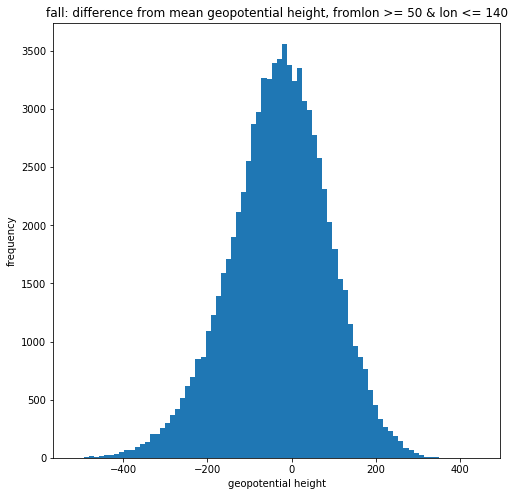

<Figure size 432x288 with 0 Axes>

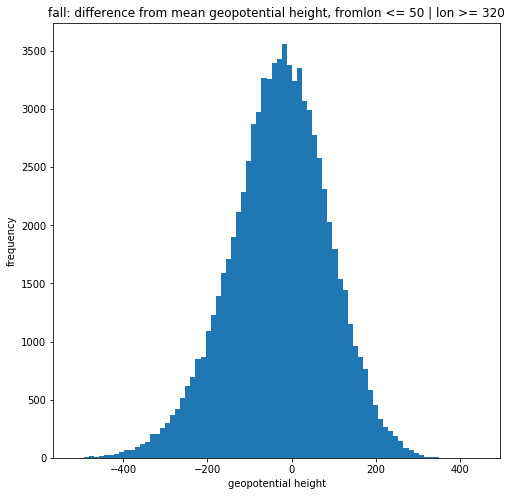

<Figure size 432x288 with 0 Axes>

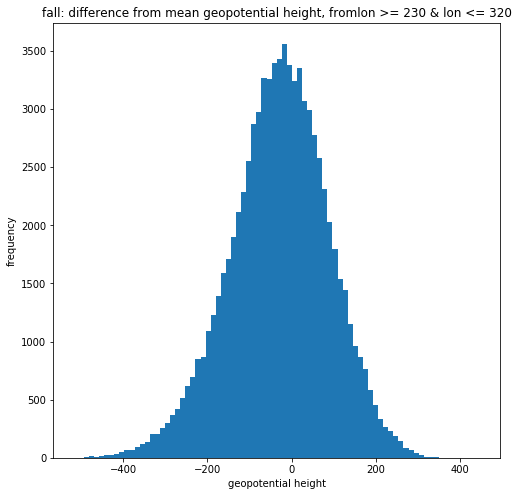

<Figure size 432x288 with 0 Axes>

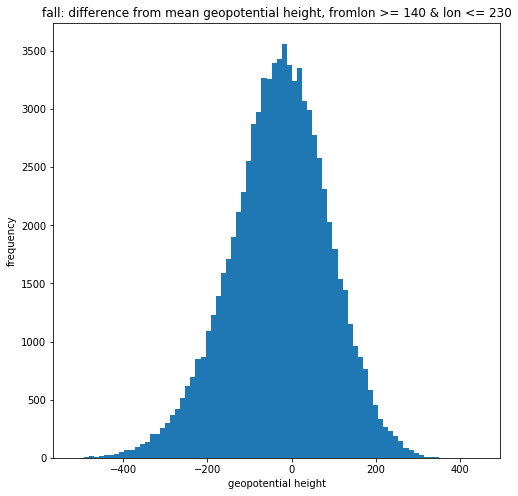

In [117]:
day4_df = avg4_df.drop_duplicates(subset=['dayavg'], keep='first', inplace=False)

i = 0
for season in season_list:
    
    #display season
    display(Markdown('## season: ' +season))
    
    #get the correct dataframe
    season_df = day4_df[day4_df['season'] == season] 
    
    #plot the histogram for the entire season
    plt.clf();
    plt.figure(figsize=(8,8))
    plt.hist(season_df['difference_climmonth'], bins = 60)
    #plt.xlim(xmin,xmax)
    plt.ylabel('frequency')
    plt.xlabel('geopotential height')
    plt.title(season + ': difference from mean geopotential height, NH fall');
    plt.show()
    
    
    
    for section in lon_sections:
        
        #get the correct dataframe
        section_df = day_df.query(section)
        
        #plot the figure
        plt.clf();
        plt.figure(figsize=(8,8))
        plt.hist(season_df['difference_climmonth'], bins = 80)
        plt.ylabel('frequency')
        plt.xlabel('geopotential height')
        plt.title(season + ': difference from mean geopotential height, from' + section);
        plt.show()
        
    i = i + 1

# Geopotential height histograms

these are the histograms that show geopotential height for each season (over every year) and for each section individually

In [118]:
day_df.columns

Index(['datetime', 'lon', 'z', 'month', 'day', 'year', 'season', 'dayavg',
       'monthmean', 'clim_monthmean', 'seasonmean', 'difference_month',
       'difference_climmonth'],
      dtype='object')

## season: winter

<Figure size 432x288 with 0 Axes>

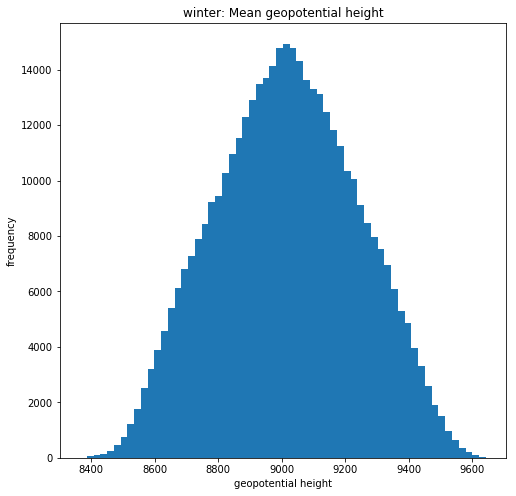

<Figure size 432x288 with 0 Axes>

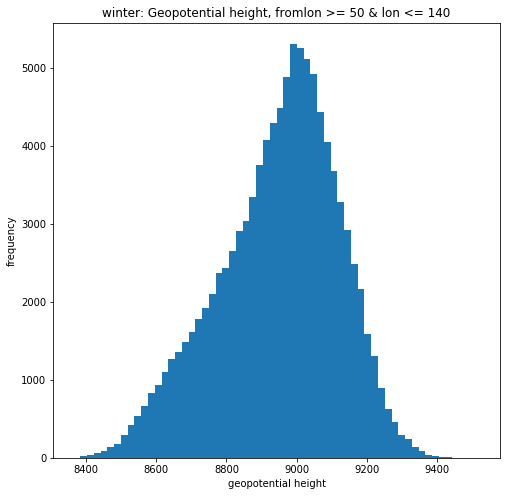

<Figure size 432x288 with 0 Axes>

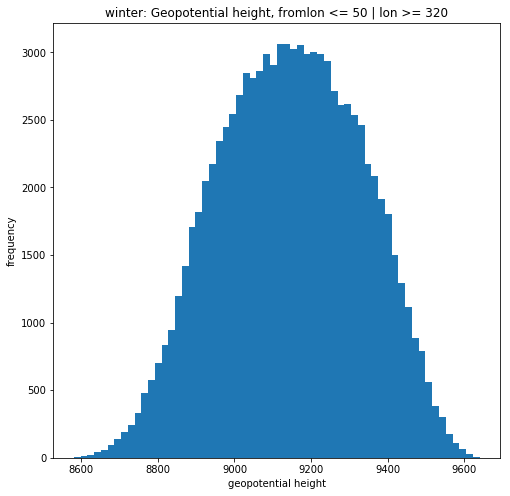

<Figure size 432x288 with 0 Axes>

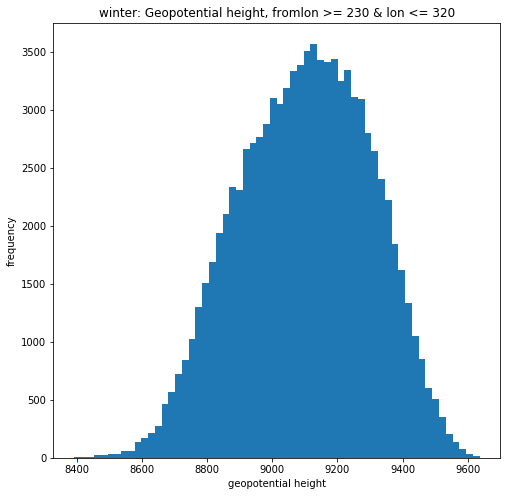

<Figure size 432x288 with 0 Axes>

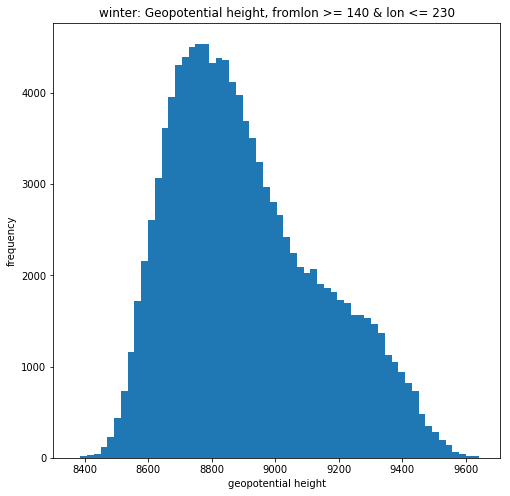

## season: spring

<Figure size 432x288 with 0 Axes>

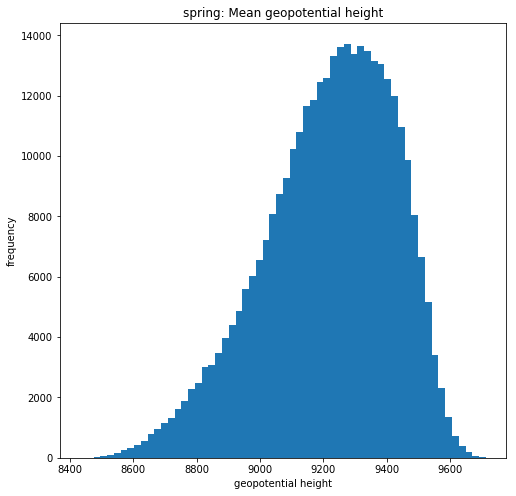

<Figure size 432x288 with 0 Axes>

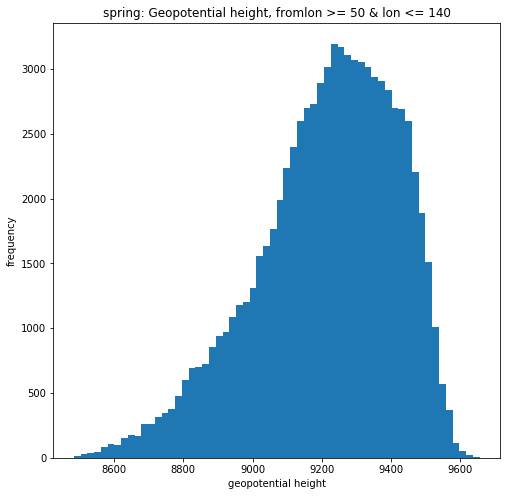

<Figure size 432x288 with 0 Axes>

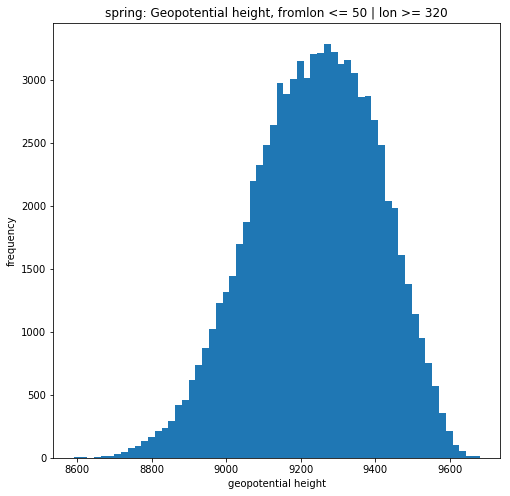

<Figure size 432x288 with 0 Axes>

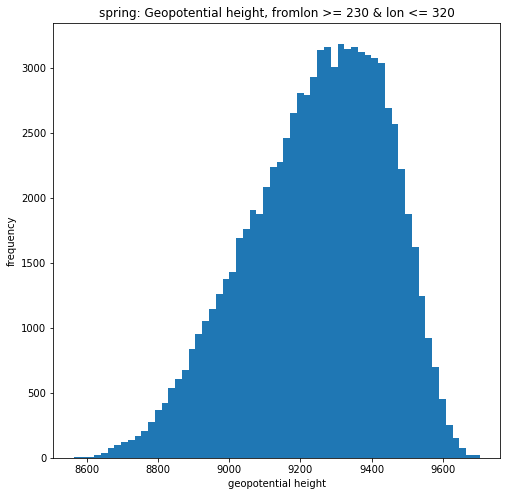

<Figure size 432x288 with 0 Axes>

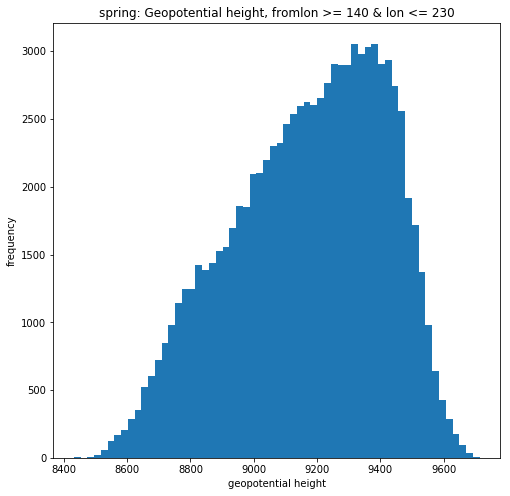

## season: summer

<Figure size 432x288 with 0 Axes>

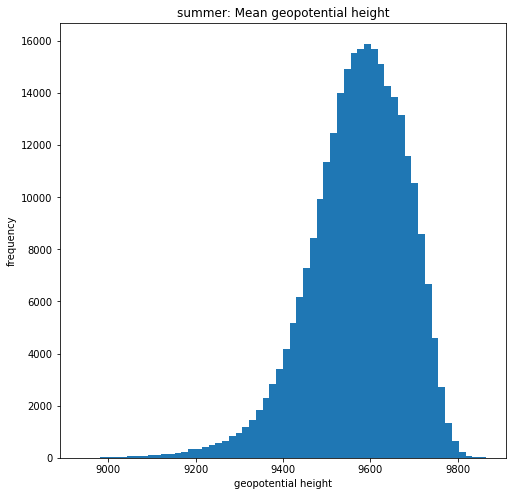

<Figure size 432x288 with 0 Axes>

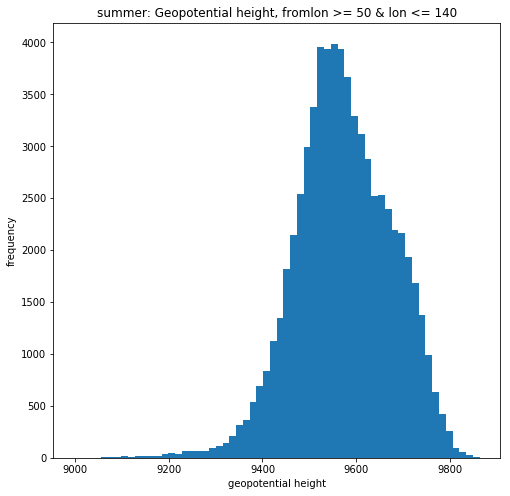

<Figure size 432x288 with 0 Axes>

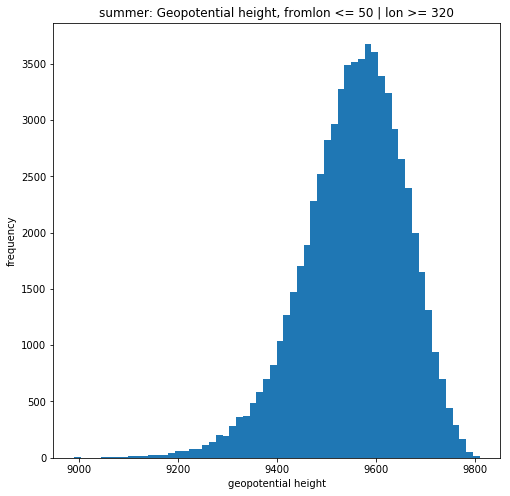

<Figure size 432x288 with 0 Axes>

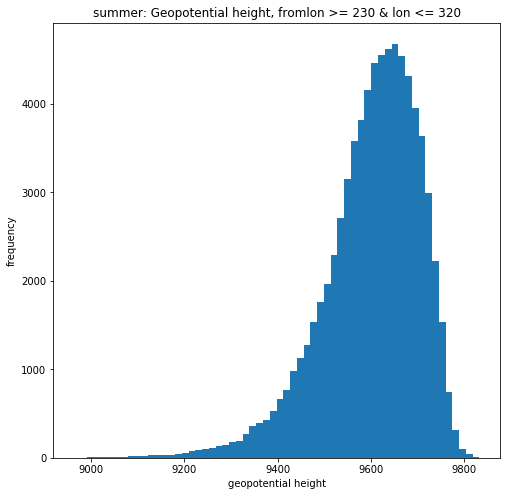

<Figure size 432x288 with 0 Axes>

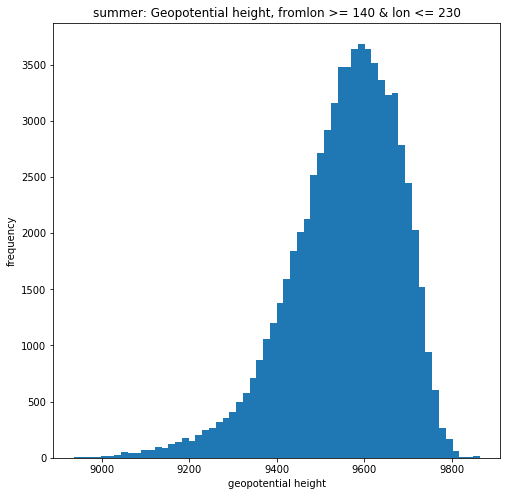

## season: fall

<Figure size 432x288 with 0 Axes>

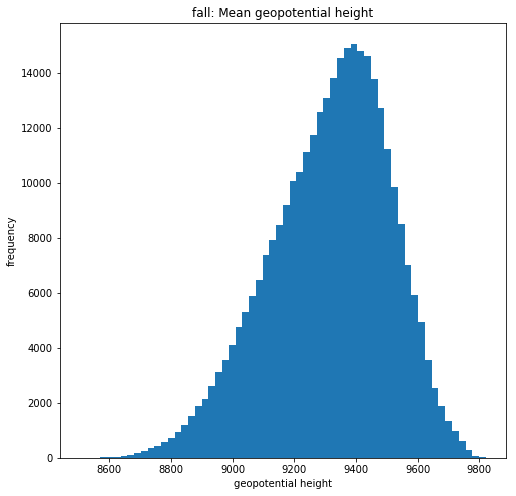

<Figure size 432x288 with 0 Axes>

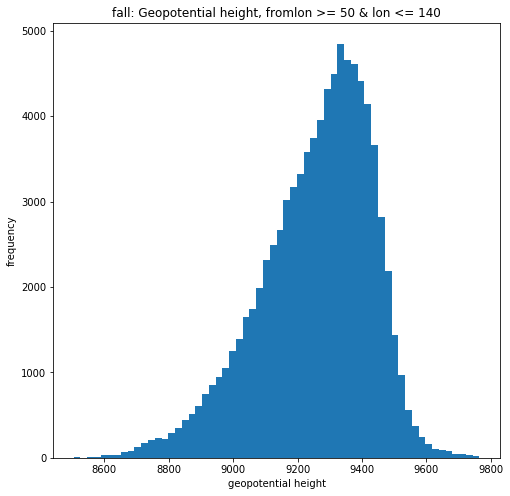

<Figure size 432x288 with 0 Axes>

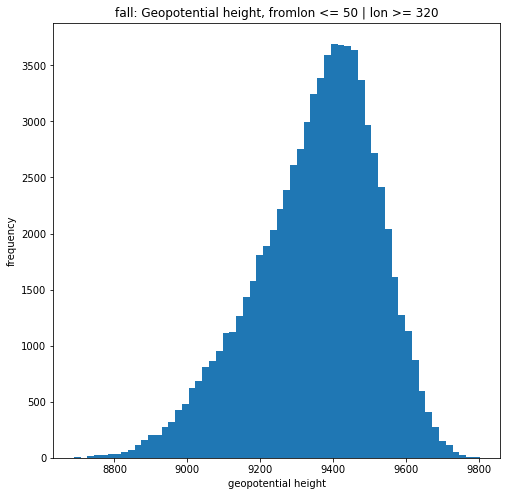

<Figure size 432x288 with 0 Axes>

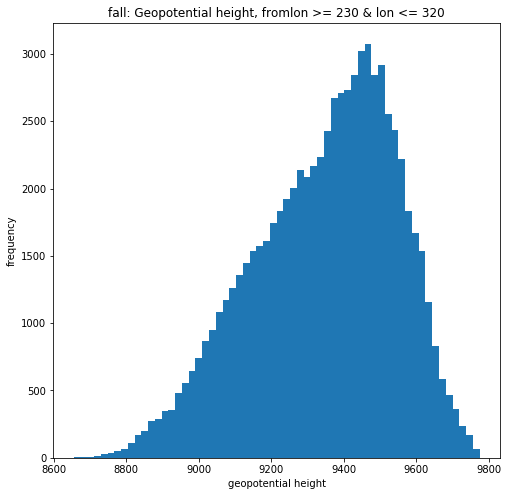

<Figure size 432x288 with 0 Axes>

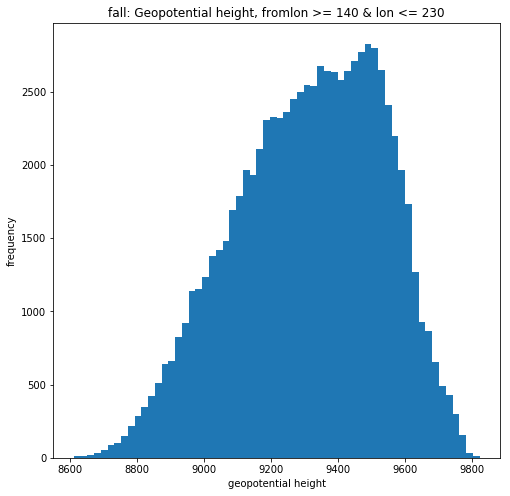

In [119]:
#drop the duplicates so am only pltting one point in each place
day_df = geopot_df.drop_duplicates(subset=['dayavg'], keep='first', inplace=False)

i = 0
for season in season_list:
    
    #display season
    display(Markdown('## season: ' + season))
    
    #get the correct dataframe
    plot_df = day_df[day_df["season"] == season]
    
    #plot the histogram for the entire season
    plt.clf();
    plt.figure(figsize=(8,8))
    plt.hist(plot_df['dayavg'], bins = 60)
    #plt.xlim(xmin,xmax)
    plt.ylabel('frequency')
    plt.xlabel('geopotential height')
    plt.title(str(season_label[i]) + ': Mean geopotential height');
    plt.show()
    
    
    
    for section in lon_sections:
        
        #get the correct dataframe
        section_df = plot_df.query(section)
        
        #plot the figure
        plt.clf();
        plt.figure(figsize=(8,8))
        plt.hist(section_df['dayavg'], bins = 60)
        plt.ylabel('frequency')
        plt.xlabel('geopotential height')
        plt.title(str(season_label[i]) + ': Geopotential height, from' + section);
        plt.show()
        
    i = i + 1

## the following code is left for reference
#### Geopotential Height Histograms with Binning of Spring and Fall
using dataframe: bins_df

spring = season_list[1]
fall = season_list[3]

#make binned dataframes for plotting
binspring_df = bins_df.query(spring)
lowspring_df = binspring_df[binspring_df['spring_bin'] == 'low']
midspring_df = binspring_df[binspring_df['spring_bin'] == 'mid']
highspring_df = binspring_df[binspring_df['spring_bin'] == 'high']


#make binned dataframes for plotting
binfall_df = bins_df.query(fall)
lowfall_df = binfall_df[binfall_df['fall_bin'] == 'low']
highfall_df = binfall_df[binfall_df['fall_bin'] == 'high']

#display season
display(Markdown('## season: spring'))
    
#plot the histogram for the entire season
plt.clf();
plt.figure(figsize=(8,8))
plt.hist(binspring_df['avgz'], bins = 60, alpha = 0.6)
plt.hist(lowspring_df['avgz'], bins = 60, alpha = 0.6)
plt.hist(midspring_df['avgz'], bins = 60, alpha = 0.6)
plt.hist(highspring_df['avgz'], bins = 60, alpha = 0.6)
#plt.xlim(xmin,xmax)
plt.ylabel('frequency')
plt.xlabel('geopotential height')
plt.title('Spring: Mean geopotential height');
plt.show()
    
    
for section in lon_sections:
        
    #get the correct dataframe
    section_df = binspring_df.query(section)
    section_low = lowspring_df.query(section)
    section_mid = midspring_df.query(section)
    section_high = highspring_df.query(section)
        
    #plot the figure
    plt.clf();
    plt.figure(figsize=(8,8))
    plt.hist(section_df['avgz'], bins = 60, alpha = 0.6)
    plt.hist(section_low['avgz'], bins = 60, alpha = 0.6)
    plt.hist(section_mid['avgz'], bins = 60, alpha = 0.6)
    plt.hist(section_high['avgz'], bins = 60, alpha = 0.6)
    plt.ylabel('frequency')
    plt.xlabel('geopotential height')
    plt.title('Spring: Geopotential height, from' + section);
    plt.show()
        


### following code is left for reference purposes
#display season
display(Markdown('## season: fall'))
    
#plot the histogram for the entire season
plt.clf();
plt.figure(figsize=(8,8))
plt.hist(binfall_df['avgz'], bins = 60, alpha = 0.6)
plt.hist(lowfall_df['avgz'], bins = 60, alpha = 0.6)
plt.hist(highfall_df['avgz'], bins = 60, alpha = 0.6)
#plt.xlim(xmin,xmax)
plt.ylabel('frequency')
plt.xlabel('geopotential height')
plt.title('Fall: Mean geopotential height');
plt.show()
    
    
for section in lon_sections:
        
    #get the correct dataframe
    section_df = binfall_df.query(section)
    section_low = lowfall_df.query(section)
    section_high = highfall_df.query(section)
        
    #plot the figure
    plt.clf();
    plt.figure(figsize=(8,8))
    plt.hist(section_df['avgz'], bins = 60, alpha = 0.6)
    plt.hist(section_low['avgz'], bins = 60, alpha = 0.6)
    plt.hist(section_high['avgz'], bins = 60, alpha = 0.6)
    plt.ylabel('frequency')
    plt.xlabel('geopotential height')
    plt.title('fall: Geopotential height, from' + section);
    plt.show()
        


## Difference for Geopotential Means histograms
(should be same figures/histograms as generated previously, but in shorter code)

i = 0
for season in season_list:
    
    #display season
    display(Markdown('## season: ' + season_label[i]))
    
    #get the correct dataframe
    season_df = day_df.query(season)
    
    #plot the histogram for the entire season
    plt.clf();
    plt.figure(figsize=(8,8))
    plt.hist(season_df['difference'], bins = 60)
    #plt.xlim(xmin,xmax)
    plt.ylabel('frequency')
    plt.xlabel('geopotential height')
    plt.title(str(season_label[i]) + ': difference from mean geopotential height, NH fall');
    plt.show()
    
    
    
    for section in lon_sections:
        
        #get the correct dataframe
        section_df = day_df.query(section)
        
        #plot the figure
        plt.clf();
        plt.figure(figsize=(8,8))
        plt.hist(section_df['difference'], bins = 60)
        plt.ylabel('frequency')
        plt.xlabel('geopotential height')
        plt.title(str(season_label[i]) + ': difference from mean geopotential height, from' + section);
        plt.show()
        
    i = i + 1